Imports

In [5]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import skimage.measure
from scipy import ndimage

In [6]:
def block_calc_2D(in_shp, trgt_shp):
    return int(in_shp[0]/trgt_shp[0]), int(in_shp[1]/trgt_shp[1])

In [7]:
# Best sobel val seems to be 7-15. Take 7 for fast compute
def plt_fun(arr, title):
    plt.imshow(arr)
    plt.title(title)
    plt.show()

Load Image

In [8]:
path = r'D:\NET_measurements\02-23\Well1\30min_XY1_EGFP_10X.tif'

img = Image.open(path)
img_arr = np.array(img)

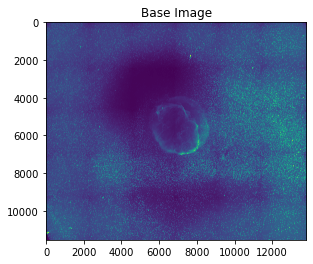

In [9]:
plt_fun(img_arr, "base_img")

Determine "granularity" of region

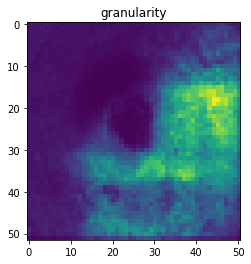

In [37]:

sobel_img = cv2.Sobel(img_arr, cv2.CV_64F, dx=1, dy=1, ksize=7)
sobel_img = sobel_img / np.max(sobel_img)

gran_steps = []
gran_steps.append(skimage.measure.block_reduce(sobel_img, (16,16), np.max)) 
gran_steps.append(ndimage.gaussian_filter(gran_steps[-1], 1))
# normalize med filter results
gran_steps.append(ndimage.median_filter(gran_steps[-1], 10)/100)
blck_0, blck_1 = block_calc_2D(gran_steps[-1].shape,(50,50))
gran_steps.append(skimage.measure.block_reduce(gran_steps[-1], (blck_0,blck_1), np.mean))

plt_fun(gran_steps[-1], "granularity")

Determine Brightness of Region

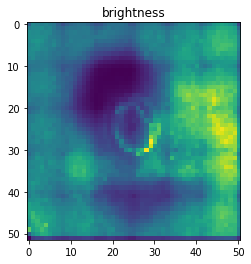

In [34]:
bright_steps = []
bright_steps.append(skimage.measure.block_reduce(img_arr, (16,16), np.mean)) 
bright_steps.append(ndimage.gaussian_filter(bright_steps[-1], 1))
gran_steps.append(ndimage.median_filter(bright_steps[-1], 10)/100)
blck_0, blck_1 = block_calc_2D(bright_steps[-1].shape, (50,50))
bright_steps.append(skimage.measure.block_reduce(bright_steps[-1], (blck_0, blck_1), np.mean))
plt_fun(bright_steps[-1], "brightness")

Process Cy5 for Normalization

In [27]:
path = r'D:\NET_measurements\02-23\Well1\30min_XY1_CY5_10X1.tif'

img = Image.open(path)
cy5_arr = np.array(img)

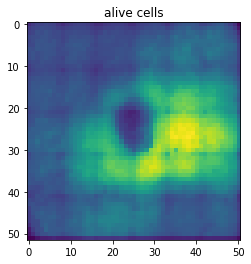

In [31]:
norm_steps = []
norm_steps.append(skimage.measure.block_reduce(cy5_arr, (16,16), np.mean)) 
norm_steps.append(ndimage.gaussian_filter(norm_steps[-1], 1))
norm_steps.append(ndimage.median_filter(norm_steps[-1], 10)/100)
blck_0, blck_1 = block_calc_2D(norm_steps[-1].shape, (50,50))
norm_steps.append(skimage.measure.block_reduce(norm_steps[-1], (blck_0, blck_1), np.mean))
plt_fun(norm_steps[-1], "alive cells")

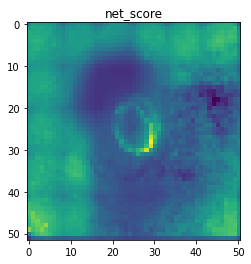

In [38]:
brightness = bright_steps[-1]
granularity = gran_steps[-1]
normalizer = norm_steps[-1]
weight_bright = 2
weight_granularity = 1

brightness = weight_bright*brightness/np.max(brightness)
# take inverse of granularity 
granularity = weight_granularity*(1-granularity/np.max(granularity))
normalizer = normalizer/np.max(normalizer)
net_score = np.multiply(brightness, granularity, normalizer)

plt_fun(net_score, "net_score")